In [1]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)
import numpy as np
import hfb_dir_init
from mmfutils.contexts import NoInterrupt
from importlib import reload
%pylab inline --no-import-all

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


# Axially Symmetric Vortices

In this notebook, I will briefly review the theory required to implement an axially symmetric configuration for solving the BdG equations (later to be extended to the ASLDA).  The relevant code will be implemented in the file [`2D_vortex.py`](2D_vortex.py).

# Regulating the BdG

We start with the issue of regularization.  In our first version we use an extremely simple approach: we simply use all states in the box, and adjust the fixed coupling constant $g_c$ so as to reproduce a particular value of the gap $\Delta$.  As a baseline, we use the following known 2D solution.

$$
  n_+ = \frac{k_F^2}{2\pi}, \qquad
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^4}{8m\pi} = \frac{1}{2}n_+\e_F, \qquad
  \tilde{C} = 0,\\
  \frac{\mu}{\e_F} = \frac{1}{2},\qquad
  \frac{\Delta}{\e_F} = \sqrt{2}\\
$$

In [2]:
import vortex_2d; reload(vortex_2d)
hbar = m = kF = 1.0
nF = kF**2/2/np.pi
eF = (hbar*kF)**2/2/m
mu = 0.5*eF
delta = np.sqrt(2)*eF

s = vortex_2d.BCS_2D(dx=1.0)
res = s.get_densities((mu, mu), delta)

In [3]:
res.n_a[0,0] + res.n_b[0,0], nF

(0.15227296982162025, 0.15915494309189535)

The $T=0$ equations in $d$ dimensions can be expressed in terms of the gap $\Delta$ and effective chemical potential $\mu_{\text{eff}} = \mu_0 + g_cn_+/2$ where $g_c>0$ represents an attractive interaction:

$$
  \Delta = g_c \nu_c, \qquad
  \epsilon_+ = \frac{\hbar^2k^2}{2m} - \mu_{\text{eff}}, \qquad
  \mathcal{E} = \frac{E}{V} 
              = \frac{\hbar^2\tau_c}{2m} - g_c(n_an_b+\nu_c^\dagger\nu_c)
              = \frac{\hbar^2\tau_c}{2m} - \Delta^\dagger\nu_c - \frac{(\mu_{\text{eff}} - \mu_0)n_+}{2},
$$

through the following integrals:
  
\begin{align}
  \nu_c &= \int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{\Delta}{2\sqrt{\epsilon_+^2 + \Delta^2}}
  &&\sim \int_{c}\frac{\d^d{k}}{(2\pi)^d}\;\frac{m\Delta}{\hbar^2 k^2},\\
  \tau_c &= \int_c\frac{\d^d{k}}{(2\pi)^d}\; k^2
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\; 
  \frac{2m^2\abs{\Delta}^2}{\hbar^4 k^2},\\
  n_+ &= \int_c\frac{\d^d{k}}{(2\pi)^d}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\; 
  \frac{2m^2\abs{\Delta}^2}{\hbar^4 k^4}.
\end{align}

In 1D, these converge, but in 2D and higher, the quantities $\tau_c$ and $\nu_c$ diverge as $\ln(k_c)$ in 2D and as $k_c$ in 3D.  The density $n_+$ converges in both 2D and 3D, although slower in 3D.  Note that the divergence in $\tau_c$ and $\nu_c$ cancel in the combination

\begin{align}
  \kappa &=\int_c\frac{\d^d{k}}{(2\pi)^d}\;\left(\frac{\hbar^2\tau_c}{2m} - \Delta^\dagger \nu_c\right) 
  &&\sim \int_c\frac{\d^d{k}}{(2\pi)^d}\;\frac{2m^2\abs{\Delta}^2\mu_{\text{eff}}}{\hbar^4 k^4},
\end{align}

which enters the energy density $\mathcal{E}$.

To regularize the theory, we must define some finite physical quantities that we can hold fixed as we take the cutoff to infinity so as to defined the parameters of the theory in a way that the physics becomes independent of the cutoff in the large cutoff limit.  In 3D we express this as follows (see [Bulgac:2011] Eq. (84) but note that our $g_c$ has the opposite sign, and we consider only unit effective mass $\alpha_+ = 1$):

\begin{align}
  \tilde{C}(n_a, n_b) &= \overbrace{- \frac{\nu_c}{\Delta}}^{-\frac{1}{g_c}} + \overbrace{\frac{1}{2}\int_c \frac{\d^d{k}}{(2\pi)^d} \frac{1}{\epsilon_+ + \I 0^+}}^{\Lambda_c} = \frac{-1}{g_c} + \Lambda_c
  &&\sim \int_c \frac{\d^d{k}}{(2\pi)^d} \frac{2m^3\abs{\Delta}^2}{\hbar^6 k^6}.
\end{align}

where the integral is take in the principal value sense.  This is motivated by the familiar Eagles-Leggett model, where this quantity is related to the two-body scattering length $a_s$:

$$
  \tilde{C}(n_a, n_b) = \frac{m}{4\pi \hbar^2 a_s}.
$$

Strictly speaking, the denominator in the integral should have $\epsilon_+ = \hbar^2k^2/2m$ without the chemical potential because the calculation of the scattering length should take place in the vacuum. To improve convergence, however, we include the chemical potential in $\epsilon_+ = \hbar^2k^2/2m - \mu$ as advocated in [BY:2002fk].  This does not change the 3D result in the limit $k_c \rightarrow \infty$ but shifts the finite portion to improve convergence.  Without this shift, the integral would behave as $\tilde{C} \sim -\int_c\d^d{k}\;2m^2\mu_{\text{eff}}/(2\pi)^d\hbar^4 k^4$.

The principal value integrals can now be performed analytically:

$$
  \Lambda_c^{1D} = \frac{m}{\hbar^2}\frac{1}{2\pi k_0}\ln\frac{k_c-k_0}{k_c+k_0}
  \rightarrow -\frac{m}{\hbar^2}\frac{1}{\pi k_c} \rightarrow 0,
  \\
  \Lambda_c^{2D} = \frac{m}{\hbar^2}\frac{1}{4\pi}
  \ln\left(\frac{k_c^2}{k_0^2}-1\right) 
  \rightarrow \frac{m}{\hbar^2}\frac{1}{2\pi}\ln\frac{k_c}{k_0},
  \\
  \Lambda_c^{3D} = \frac{m}{\hbar^2}\frac{k_c}{2\pi^2} 
  \left(1 - \frac{k_0}{2k_c}\ln\frac{k_c+k_0}{k_c-k_0}\right)
  \rightarrow \frac{m}{\hbar^2}\frac{k_c}{2\pi^2},
$$

where

$$
  \frac{\hbar^2k_0^2}{2m} - \mu = 0, \qquad
  \frac{\hbar^2k_c^2}{2m} - \mu = E_c.
$$

The latter equation allows us to replace the momentum cutoff $k_c$ in terms of an energy cutoff $E_c$ which is of use in inhomogeneous systems.

[BY:2002fk]: https://doi.org/10.1103/PhysRevLett.88.042504 'Aurel Bulgac and Yongle Yu, "Renormalization of the Hartree-Fock-Bogoliubov Equations in the Case of a Zero Range Pairing Interaction", prl 88(4), 042504 (2002) [nucl-th/0106062v3](http://arXiv.org/abs/nucl-th/0106062v3)'

[Bulgac:2011]: http://dx.doi.org/10.1007/978-3-642-21978-8_9 'Aurel Bulgac, Michael McNeil Forbes, and Piotr Magierski, "The Unitary Fermi Gas: From Monte Carlo to Density Functionals",  836, 305 -- 373 (2012) [1008.3933](http://arXiv.org/abs/1008.3933)'

**Comments:**

As we take the cutoff $k_c\rightarrow \infty$ we notice the following:

* In 1D, $\Lambda_c \rightarrow 0$:
  * This indicates that $\tilde{C} = -\nu_c/\Delta = -1/g_c$ is finite, and the theory is well defined in this limit with finite anomalous density $\nu$, and finite cutoff $g=v_0$.  In this case, no cutoff is needed, but one might still like to use the cutoff procedure to improve the convergence.  In particular, when working on a lattice, there is a maximum momentum that can be represented $k_\max$ which will limit the convergence roughly according to the behavior discussed above.  For example, $\nu \sim 1/k_\max$ will converge slowly, requiring large lattices to approach the physical limit.  Using the cutoff procedure and Thomas-Fermi completion discussed below will speed this convergence.
  * Since $g$ is finite, one must also include the Hartree corrections to the chemical potentials:
    
    $$
      \mu_{a,b}^{\mathrm{eff}} = \mu_{a,b} + g n_{b,a}.
    $$

    This complicates things a bit because now the effective potentials depend on the density.  One can still work with fixed $\mu$, but this means that the self-consistent solution is the solution in a funky background potential which has been chosen to absorb these corrections.
    
* In 2D and 3D, $\Lambda_c \rightarrow \infty$ divergence.  This means that if we fix $\tilde{C}$ to be finite, then $g_c \rightarrow 0$.  In this case, the Haretree corrections vanish and the effective chemical potentials do not depend on the state:

  $$
    \mu^{\mathrm{eff}} = \mu = \mu_0 - V(x).
  $$
  
  This allows us to easily work in the grand-canonical ensemble.
  
* In 3D, $\Lambda_c$ is independent of $k_0$ in the limit of large cutoff.  This means that the including the pole, which improves the convergence, does not affect the usual identification of the scattering length.

* In 2D, however, there remains a dependence on $k_0$ in the large cutoff limit.  This means that our procedure for specifying the functional through $\tilde{C}$ depends on $k_0$.  This is not ideal for a density function because it means that the physical interpretation of the results depend on the external potential - i.e. the DFT is not independent of the potential as it should be.  The previous point that Hartree terms vanish helps a bit since $k_0$ then depends only on the external trap and bare chemical potentials.  (Otherwise, the DFT would be state-dependent which would be even worse!)

  The results of this simple approach must be interpreted instead as the results of a DFT fixing the following combination:
  
  $$
    \tilde{C} - \frac{m}{2\pi \hbar^2}\ln k_0
  $$

  which becomes independent of $k_c$ in the limit of large cutoff.  Note that this diverges at the classical turning points where $k_0 = 0$.  I am not sure if this poses any issues, and perhaps is expected and related to some of the divergent behaviour in 2D where results depend on the boundary conditions quite strongly. *(One should include a dimensionless factor in the log to render $k_0/\tilde{k}$ dimensionless, but this will just be absorbed into the constant value.)*  In any case, this simple regularization procedure should be fine for qualitative and exploratory work keeping in mind that the results might depart strongly from "physical" 2D results near the turning points.

## Example: 2D

As an example, consider homogeneous states in 2D.  Suppose one knows $\Delta$ and $\mu_+$, how should $\tilde{C}$ be determined?  In principle, one can simply compute:

$$
  \tilde{C}(n_a, n_b) = \lim_{k_c\rightarrow\infty}\left(
    - \frac{\nu_c}{\Delta} + \frac{1}{2}\int_0^{k_c} \frac{\d{k}}{2\pi} \frac{k}{\epsilon_+ + \I 0^+}
  \right)
  = \frac{1}{2} \int_0^{\infty}\frac{\d{k}}{2\pi}\left(- \frac{k}{\sqrt{\epsilon_+^2 + \Delta^2}} +  \frac{k}{\epsilon_+ + \I 0^+}\right).
$$

However, numerically computing this integral can be challenging because of the pole.  We can proceed as we would were we performing the computation in a discrete basis. 

## Thomas Fermi Completion

To facilitate convergence in the case when the solutions vary slowly, we can include states with $E>E_c$ by assuming that on length-scales smaller than $1/k_c$ the solution is homogeneous and performing the integrals.  This can be done exactly (numerically completing the integrals) or as a series approximation in $1/k_c$.

As an example, consider the computation of the gap equation.  We will illustrate this with symmetric homogeneous matter in 2D.  As discussed above, this presents some difficulties due to the divergent behaviour of $\Lambda_c$.  In a typical calculation, this would proceed as follows:

1. First compute the anomalous density $\nu_c$ by diagonalizing the Hamiltonian and include only states with $\abs{E}<E_c = \hbar^2k_c^2/2m$.  For 2D homogeneous matter this would be

   $$
     \nu_c = \int_{0}^{k_c}\frac{k\d{k}}{2\pi}\;\frac{\Delta}{2\sqrt{\epsilon_+^2 + \Delta^2}}.
   $$

2. We would then use the regulated equation for $\tilde{C}$ to compute the coupling constant:

   $$
     g_c = \frac{1}{\Lambda_c - \tilde{C}}.
   $$
  
3. Finally, we would use the gap equation to find the self-consistency condition $\Delta = g_c\nu_c$.

Putting these together, we have:

$$
  \tilde{C}(n_a, n_b) = -\frac{\nu_c}{\Delta} + \Lambda_c + \order(k_c^{-4}) 
  = -\int_{0}^{k_c}\frac{k\d{k}}{2\pi}\;\frac{\Delta}{2\sqrt{\epsilon_+^2 + \Delta^2}}
  + \frac{1}{2}\int_{0}^{k_c}\frac{k\d{k}}{2\pi}\; \frac{1}{\epsilon_+ + \I 0^+}
  + \order(k_c^{-4}).
$$

This is missing the contributions from the states above $k_c$ which would be corrected by including the full integrals:

$$
  \tilde{C}(n_a, n_b) = -\frac{\nu_c}{\Delta} + \Lambda_c
  + \frac{1}{2}\int_{k_c}^{\infty}\frac{k\d{k}}{2\pi}\;\left(
    \frac{1}{\epsilon_+ + \I 0^+} -\frac{1}{\sqrt{\epsilon_+^2 + \Delta^2}}\right).
$$

We call this latter correction the "Thomas-Fermi Completion".  The idea is to assume that on length scales shorter than $1/k_c$, the system is approximately homogeneous and so one can use the homogeneous equations to complete the contributions to various pieces from the missing states.  One either computes the integrals above $k_c$ numerically, or performs a series expansion in $k_c^{-1}$ to compute the corrections at each point in space.  (These corrections will in general depend on position because the quantities in the integrand such as $\Delta(x)$ will depend depend on position.)

*Aside: this procedure also allows us to compute $\tilde{C}$ in two dimensions.  Although the integral is finite, numerically computing through the pole is a challenge since one really needs a PV integral.  If we follow this procedure, however, we can compute $\nu_c$ numerically, $\Lambda_c$ analytically, then apply the TF completion.*



\begin{align}
\newcommand\intdk{\int\frac{\d^d{k}}{(2\pi)^d}\;}
  n_+ &= \intdk\overbrace{\left(1 - \frac{\epsilon^+_k}{E_k}
               \underbrace{\bigl(f(\omega_-) - f(\omega_+)\bigr)}_{f_\nu}
          \right)}^{f_+}, &
  n_- &= \intdk\overbrace{\bigl(f(\omega_+) - f(-\omega_-)\bigr)}^{f_-},\\
  \tau_+ &= \intdk k^2f_+, &
  \tau_- &= \intdk k^2f_-,\\
  \nu &= \intdk\frac{\Delta}{2E_k}\overbrace{\bigl(f(\omega_-)-f(\omega_+)\bigr)}^{f_\nu}, &
  \kappa &= \intdk \left(\frac{\hbar^2k^2}{2m_+}f_+ 
                         - \frac{\abs{\Delta}^2}{2E_k}f_\nu\right),\\
  \tilde{C} &= \intdk \frac{1}{2}\left(
    \frac{1}{\epsilon_+ + \I 0^+} - \frac{f_\nu}{E_k}\right).
\end{align}

*(I have not carefully considered the thermal factors for $\tilde{C}$.  In principle, it should be fine to define $\tilde{C}$ this way, but it should also depend on the fugacity or a similar parameter.)*


$$
  n^{3D}_+ \approx \int_{E<E_c}\frac{\d^d{k}}{(2\pi)^d}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  + \frac{m^2\abs{\Delta}^2}{k_c \hbar^4\pi^2}
  + \frac{4m^3\abs{\Delta^2}\mu}{3\hbar^6 \pi^2 k_c^3}
  + \order(k_c^{-5}),
  \\
  \kappa^{3D} \approx \int_{E<E_c}\frac{\d^d{k}}{(2\pi)^d}\;\left(\frac{\hbar^2\tau_c}{2m} - \Delta^\dagger \nu_c\right)
  + \frac{m^2 \mu \abs{\Delta}^2}{\hbar^4 \pi^2 k_c}
  + \frac{m^3\abs{\Delta}^2(8\mu^2-\abs{\Delta}^2)}{6\hbar^6\pi^2 k_c^3}
  +\order(k_c^{-5}),  
$$



### 3D

Here we check the results for homogeneous matter in various dimensions.  In 3D can compare these with the results we know for the BdG equation (Eagles-Leggett model) at unitarity:

$$
  \newcommand{\E}{\mathcal{E}}\newcommand{\e}{\epsilon}
  n_+ = n_a+n_b = \frac{k_F^3}{3\pi^2}, \qquad
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^5}{10m\pi^2} = \frac{3}{5}n_+\e_F, \qquad
  \tilde{C} = 0,
$$
\begin{align*}
  \xi = \frac{\E}{\E_{FG}}
      = \frac{\mu}{\e_F} &= 0.59060550703283853378393810185221521748413488992993\cdots\\
  \frac{\Delta}{\e_F} &= 0.68640205206984016444108204356564421137062514068346\cdots\\
  \frac{\Delta}{\mu}& = 1.162200561790012570995259741628790656202543181557689\cdots.
\end{align*}

### 2D

In 2D, we must compute results but we seem to have:

$$
  n_+ = \frac{k_F^2}{2\pi}, \qquad
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^4}{8m\pi} = \frac{1}{2}n_+\e_F, \qquad
  \tilde{C} = 0,\\
  \frac{\mu}{\e_F} = \frac{1}{2},\qquad
  \frac{\Delta}{\e_F} = \sqrt{2}\\
$$

### 1D

In 1D, we have the following:

$$
  n_+ = \frac{k_F}{\pi}, \qquad 
  \e_F = \frac{\hbar^2 k_F^2}{2m}, \qquad
  \E_{FG} = \frac{k_F^3}{3m\pi} = \frac{2}{3}n_+\e_F, \qquad
  \tilde{C} = -\frac{m}{\hbar^2k_F},\\
  \frac{\mu}{\e_F} = 0.28223521359741266,\qquad
  \frac{\Delta}{\e_F} = 0.41172622996179004.
$$

In [5]:
import tf_completion as tf;reload(tf)

# Test BdG at unitary point.
m = hbar = kF = 1.0
eF = (hbar*kF)**2/2/m
nF = kF**3/3/np.pi**2
E_FG = 3*nF*eF/5
xi = 0.59060550703283853378393810185221521748413488992993
mu = mu_a = mu_b = xi*eF
delta = 0.68640205206984016444108204356564421137062514068346*eF

args = dict(mu_a=mu_a, mu_b=mu_b, delta=delta, m_a=m, m_b=m, hbar=hbar, d=3, T=0.0)
assert np.allclose(tf.integrate(tf.n_p_integrand, **args).n, nF)
assert np.allclose(tf.compute_C(**args).n, 0)
#assert np.allclose(tf.integrate(tf.kappa_integrand, **args).n, E_FG)

# The kappa integral has roundoff error for large k, so we use fixed k_c
assert np.allclose(tf.integrate(tf.kappa_integrand, k_c=100, **args).n,
                   xi*E_FG, rtol=1e-2)

In [6]:
import tf_completion as tf;reload(tf)

m = hbar = kF = 1.0
nF = kF/np.pi
eF = (hbar*kF)**2/2/m
E_FG = 3*nF*eF/5
C1_unit = m/hbar**2/kF

mu = mu_a = mu_b = 0.28223521359741266*eF
delta = 0.41172622996179004*eF

args = dict(mu_a=mu_a, mu_b=mu_b, delta=delta,
            m_a=m, m_b=m, hbar=hbar, d=1, T=0.0)
assert np.allclose(tf.integrate(tf.n_p_integrand, **args).n, nF)
assert np.allclose(tf.compute_C(**args).n, -C1_unit)

In [7]:
import homogeneous;reload(homogeneous)
s = homogeneous.Homogeneous1D()
v0, ns, mus = s.get_BCS_v_n_e((mu, mu), delta)
ns.sum(), nF

(0.3183098861838096+/-6.6210538783074394e-12, 0.3183098861837907)

In [8]:
import vortex_2d;reload(vortex_2d)
m = hbar = kF = 1.0
nF = kF/np.pi
eF = (hbar*kF)**2/2/m
E_FG = 3*nF*eF/5
C1_unit = m/hbar**2/kF
mu = mu_a = mu_b = 0.28223521359741266*eF
delta = 0.41172622996179004*eF

s = vortex_2d.BCS_1D(Nx=32, Lx=10.0)
n_a, n_b, nu = s.get_densities(mus=(mu_a, mu_b), delta=delta)
(n_a+n_b).mean(), nu.mean()

(0.3156047098287266, (-0.20407601464713004+9.931658120757415e-17j))

In [9]:
import bcs;reload(bcs)
s = bcs.BCS(N=32, L=100.)
s.get_R_twist_average((mu, mu), delta)[0,0], nF

((0.47855485355396865+0j), 0.3183098861837907)

0.009513876275553185

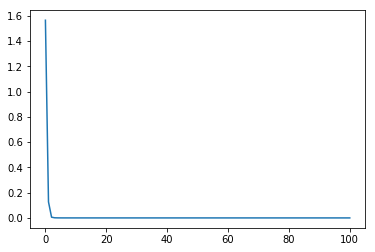

In [10]:
k = np.linspace(0, 100, 100)
if 'd' in args:
    del args['d']
plt.plot(k, tf.n_p_integrand(k**2,k**2, **args))
np.trapz(tf.n_p_integrand(k**2, k**2,  **args)*k**2/2/np.pi**2, k)

In [12]:
from scipy.optimize import brentq
import homogeneous
import tf_completion;reload(tf_completion)

m = hbar = 1.0
np.random.seed(1)
delta = np.random.random(1)
lam_inv = 0.5
lam = 1./lam_inv

def _lam(mu_eff):
    E_N_E_2, _lam = homogeneous.BCS(mu_eff=mu_eff,  delta=delta)
    return _lam - lam

mu_eff = brentq(_lam, 0.6, 0.8)

v_0, n, mu, e = homogeneous.get_BCS_v_n_e(mu_eff=mu_eff, delta=delta)
E_N_E_2, lam = homogeneous.BCS(mu_eff=mu_eff,  delta=delta)
mu_tilde = (hbar**2/m/v_0**2)*mu
assert np.allclose(lam, 1./0.5)
assert np.allclose(mu_tilde, 0.0864, atol=0.0005)    
assert np.allclose(E_N_E_2, -0.3037, atol=0.0005)

args = dict(mu_a=mu_eff, mu_b=mu_eff, delta=delta, m_a=m, m_b=m, hbar=hbar, T=0.0)
nu = tf_completion.integrate(tf_completion.nu_integrand, d=1, **args)
v_0 = delta/nu.n
mu_tilde = (hbar**2/m/v_0**2)*mu
assert np.allclose(mu_tilde, 0.0864, atol=0.0005)   
#tf_completion.n_p_integrand(0, **args)
#plt.plot(k, i(k))
#plt.plot(k, tf_completion.n_p_integrand(k**2, **args)*k**2/2/np.pi**2)

E:\Projects\Physics\quantum-fermion-theories\mmf-hfb\Docs/../mmf_hfb\homogeneous.py:28: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ufloat(*sp.integrate.quad(f, kF, k_inf, limit=limit, **args)))


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<built-in function abs>) with argument(s) of type(s): (array(float64, 1d, C))
Known signatures:
 * (int8,) -> int8
 * (int16,) -> int16
 * (int32,) -> int32
 * (int64,) -> int64
 * (float32,) -> float32
 * (float64,) -> float64
 * (complex64,) -> float32
 * (complex128,) -> float64
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<built-in function abs>)[0m
[0m[1m[2] During: typing of call at E:\Projects\Physics\quantum-fermion-theories\mmf-hfb\Docs/../mmf_hfb\tf_completion.py (169)
[0m
[1m
File "..\mmf_hfb\tf_completion.py", line 169:[0m
[1mdef nu_integrand(ka2, kb2, mu_a, mu_b, delta, m_a, m_b, hbar, T):
    <source elided>
    e_m, e_p = (e_a - e_b)/2, (e_a + e_b)/2
[1m    E = np.sqrt(e_p**2 + abs(delta)**2)
[0m    [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function nu_integrand at 0x000001DD8E98E730>))[0m
[0m[1m[2] During: typing of call at E:\Projects\Physics\quantum-fermion-theories\mmf-hfb\Docs/../mmf_hfb\tf_completion.py (293)
[0m
[1m
File "..\mmf_hfb\tf_completion.py", line 293:[0m
[1m        def integrand(k):
            <source elided>
            k2 = k**2
[1m            return f(k2, k2, *args) / np.pi
[0m            [1m^[0m[0m


In [13]:
# 2D Values
hbar = m = 1
kF = 1.0
eF = (hbar*kF)**2/2/m
nF = kF**2/2/np.pi
mu = 0.5*eF
delta = np.sqrt(2)*eF

In [14]:
args = dict(mu_a=mu, mu_b=mu, delta=delta, m_a=m, m_b=m, hbar=hbar, T=0.0)
#tf_completion.integrate(tf_completion.n_p_integrand, d=3, **args), nF

In [ ]:
from mmfutils.math.integrate import mquad
import vortex_2d;
reload(vortex_2d)
bcs = vortex_2d.BCS0( T=0.0)
def integrand(k, d=2):
    ns_nu = bcs.get_ns_nu(k, mus=(mu, mu), delta=delta)
    if d == 2:
        return ns_nu*k/2/np.pi
    
n_a, n_b, nu_c = mquad(integrand, 0, 1000000.0, points=[kF]).ravel()
#assert np.allclose(nF, n_a+n_b)
#nu
nF - n_a - n_b

In [19]:
import vortex_2d;reload(vortex_2d)
bcs = vortex_2d.BCS(T=0.0, Lxy=(20.0, 20.0))
kF = 1.0
eF = kF**2/2/m
nF = kF**2/2/np.pi
mu = 0.5*eF
delta = np.sqrt(2)*eF
R = bcs.get_R(mus=[mu, mu], delta=delta)

In [20]:
bcs.get_densities(R)
N = R.shape[0]//2
n_a = np.diag(R[:N,:N])
n_b = np.diag(R[N:,N:])
2*n_a.mean().real, 2*n_b.mean().real, nF

AttributeError: 'BCS' object has no attribute 'get_densities'

In [ ]:
bcs.get_densities(R)
N = R.shape[0]//2
n_a = np.diag(R[:N,:N])
n_b = np.diag(R[N:,N:])
2*n_a.mean().real, 2*n_b.mean().real, nF

In [ ]:
kc = np.sqrt(2*m*bcs.Ec)
kc, integrate(n_integrand, mu=mu, delta=delta, d=2, k_c=kc)

In [ ]:
from functools import partial
import numpy as np
from scipy.integrate import quad
from uncertainties import ufloat

hbar = 1.
m = 1.

def n_integrand(k, mu, delta):
    ep = (hbar*k)**2/2/m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return (1 - ep/E)

def nu_integrand(k, mu, delta):
    ep = (hbar*k)**2/2./m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return delta/2/E

def tau_integrand(k, mu, delta):
    ep = (hbar*k)**2/2./m - mu
    E = np.sqrt(ep**2 + abs(delta)**2)
    return k**2*(1. - ep/E)

def E_integrand(k, mu, delta):
    tau = tau_integrand(k, mu=mu, delta=delta)
    nu = nu_integrand(k, mu=mu, delta=delta)
    #n = n_integrand(k, mu=mu, delta=delta)
    return hbar**2*tau/2/m - delta*nu

def C_integrand(k, mu, delta, shift=0.0):
    """Integrand without chemical potential shift.
    
    This works better for numerical integration with infinite limits.
    """
    ep = (hbar*k)**2/2/m - mu
    return (0.5/(ep+shift*1j) - nu_integrand(k, mu=mu, delta=delta)/delta).real

def C0_integrand(k, mu, delta):
    """Integrand without chemical potential shift.
    
    This works better for numerical integration with infinite limits.
    """
    k0 = np.sqrt(2*m*mu)/hbar
    ep0 = (hbar*k)**2/2/m
    return (0.5/ep0 - nu_integrand(k, mu=mu, delta=delta)/delta).real

def integrate(integrand, mu, delta, k0=0, k_c=np.inf, d=3, **kw):
    if d == 1:
        f = lambda k: integrand(k, mu=mu, delta=delta)/np.pi
    elif d == 2:
        f = lambda k: integrand(k, mu=mu, delta=delta)*k/2/np.pi
    elif d == 3:
        f = lambda k: integrand(k, mu=mu, delta=delta)*k**2/2/np.pi**2
    return quad(f, k0, k_c, **kw)

def Lambda(k_c, mu, d=3):
    k_0 = np.sqrt(2*m*mu)/hbar
    if d == 3:
        return m/hbar**2 * k_c/2/np.pi**2*(
            1 - k_0/2/k_c*np.log((k_c+k_0)/(k_c-k_0)))
    elif d == 2:
        return m/hbar**2/4/np.pi * np.log((k_c/k_0)**2-1)
    elif d == 1:
        return m/hbar**2/2/np.pi/k_0 * np.log((k_c-k_0)/(k_c+k_0))
    
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**3/3/np.pi**2
E_FG = 3./5*n_F*e_F
mu = 0.59060550703283853378393810185221521748413488992993*e_F
delta = 1.162200561790012570995259741628790656202543181557689*mu
delta = 0.68640205206984016444108204356564421137062514068346*e_F

kw = dict(mu=mu, delta=delta)
n_p = ufloat(*integrate(n_integrand, **kw))
assert np.allclose(n_p.n, n_F)

C0 = ufloat(*integrate(C0_integrand, **kw))
assert np.allclose(C0.n, 0)

Here we compute the 2D results.  We can simply integrate the $\tilde{C}$ equation, but numerically this has issues near the pole.  We circumvent these by shifting the pole into the complex plane, but have limited accuracy.  Using the TF completion trick discussed above, we can compute this at finite $k_c$ to high precision in a manner who's result is independent of $k_c$.  For inhomogeneous states, the results would depend on $k_c$ to an extent determined by how much the assumption of local homogeneity is violated.

In [ ]:
## 2D values.  Here we need to use the TF completion trick:
e_F = 1.0
k_F = np.sqrt(2*m*e_F)
n_F = k_F**2/2/np.pi
E_FG = 1./2*n_F*e_F
mu = e_F/2.0
delta = np.sqrt(2)*e_F

def compute_C(k_c, **kw):
    """Compute Ctilde using the TF completion trick."""
    nu_c = ufloat(*integrate(nu_integrand, k_c=k_c, **kw))
    Lambda_c = Lambda(k_c, mu=kw['mu'], d=kw['d'])
    C_TF = ufloat(*integrate(C_integrand, k0=k_c, **kw))
    return Lambda_c - nu_c/kw['delta'] + C_TF

kw.update(mu=mu, delta=delta, d=2)
n2_p = ufloat(*integrate(n_integrand, **kw))
assert np.allclose(n2_p.n, n_F)

C = compute_C(2.0, epsabs=1e-14, epsrel=1e-14, **kw)
assert np.allclose(C.n, 0)

In [ ]:
((integrate(E_integrand, mu=mu, delta=delta, k0=0, k_c=10)[0]
  + integrate(E_integrand, mu=mu, delta=delta, k0=10, k_c=20)[0]
  + integrate(E_integrand, mu=mu, delta=delta, k0=20, k_c=np.inf)[0]),
 0.59060550703283853378393810185221521748413488992993*E_FG)

In [ ]:
from scipy.special import hyp2f1
def P(n, x):
    return hyp2f1(-n,n+1,1,(1-x)/2.0)

def f(alpha, a):
    return -np.pi/np.sin(np.pi*alpha)*P(alpha, -a)

y_U = 0.65222953196994067235
p0 = np.sqrt(2*m*mu)
print(-p0**5*(f(5./2, y_U) 
        - y_U*f(3./2, y_U) 
        + 0.5*(1-y_U**2)*f(0.5, y_U))/y_U**(5./2)/8/np.pi**2, 
      0.59060550703283853378393810185221521748413488992993*E_FG)

5./4*(4./3)**(5./3)*((f(5./2, y_U) - y_U*f(3./2, y_U) + 0.5*(1-y_U**2)*f(0.5, y_U)) 
 / abs(f(3./2, y_U) - y_U*f(1./2, y_U))**(5./3))

In [ ]:
err = []
p = 5
ks = np.linspace(10.0**(-p),100**(-p),100)**(-1./p)
for k_c in ks:
    E = ufloat(*integrate(E_integrand, mu=mu, delta=delta, k_c=k_c))
    E_ = 0.59060550703283853378393810185221521748413488992993*E_FG
    err.append((E_ - E).n)
err = np.array(err)
dE = ((m/hbar**2)**2*mu*delta**2/np.pi**2/ks
      + (m/hbar**2)**3*delta**2 * (8*mu**2-delta**2)/6/np.pi**2/ks**3)
err -= dE
plt.plot(1./ks**p, err, '+')
#plt.plot(1./ks, dE+0*0.0038)
#plt.xlim(0, 0.1);plt.ylim(0, err.max());

In [ ]:
integrate(C_integrand, k0=0, **kw)
kw
## 1D values
kw.update(d=1)
n1_p = ufloat(*integrate(n_integrand, **kw))
C1 = ufloat(*integrate(C0_integrand, **kw))
n1_p, C1

The energy density is hard to compute because of roundoff error:

In [ ]:
%pylab inline
E = np.linspace(0,2,100)
wp = E
wm = -E
h.T = 0.
plt.plot(E, 1 - h.f(-wm) - h.f(wp))
plt.plot(E, h.f(wm) - h.f(wp), '+')

In [ ]:
k = np.linspace(0,2,100)
plt.plot(k, h._C0_integrand(k))
plt.plot(k, C0_integrand(k, mu=mu, delta=delta), '+')

In [ ]:
import homogeneous_mmf;reload(homogeneous_mmf)
h = homogeneous_mmf.Homogeneous(dim=2)
h.get_C0(mus=(mu, mu), delta=delta)
h.get_n_p(mus=(mu, mu), delta=delta)

In [ ]:
3*n_p*mu/5 - n_p*mu - E[0]

In [ ]:
E = ufloat(*integrate(E_integrand, mu=mu, delta=delta))
E

Here is how we would do it with the cutoff:

In [ ]:
k_c = 100.0
L3 = Lambda(k_c, mu=mu)
g_c = -1./(C0.n - L3)
assert np.allclose(g_c*integrate(nu_integrand, mu, delta, k_c=k_c)[0], delta)

## Lattice Regularization

When we perform the calculations on a lattice, we have a natural cutoff specified by the basis.  Unfortunately, one does not obtain uniform convergence as a function of this cutoff unless one is careful to choose it appropriately.  This is because the shell corrections do not converge.

## Hamiltonian

The simplest implementation explicitly forms the Hamiltonian matrix.  This is not ideal for larger systems, but is a quick way to check the code.  Here we show how to form the kinetic energy by using the FFT to compute the matrix $U$ that implements the FFT.

In [ ]:
Nx, Ny = 64, 64
H = np.eye(Nx*Ny).reshape(Nx, Ny, Nx, Ny)
U = np.fft.fftn(H, axes=[0,1]).reshape(Nx*Ny, Nx*Ny)
psi = np.random.random((Nx, Ny))
np.allclose(np.fft.fftn(psi).ravel(), U.dot(psi.ravel()))

In [ ]:
from importlib import reload
from mmf_hfb import vortex_2d;reload(vortex_2d)
s = vortex_2d.BCS(Nxy=(16,)*2)
k_c = abs(s.kxy[0]).max()
E_c = (s.hbar*k_c)**2/2/s.m
s = vortex_2d.BCS(Nxy=(16,)*2, E_c=E_c)
kw = dict(mus=(mu, mu), delta=delta)
#R = s.get_R(**kw)
H = s.get_H(**kw)
assert np.allclose(H, H.T.conj())

In [ ]:
plt.plot(E, s.f(E, E_c=np.inf))
plt.axvline(E_c, c='y')
plt.axvline(-E_c, c='y')

In [ ]:
E

In [ ]:
%pylab inline --no-import-all
Nx, Ny = s.Nxy
%time E, psi = np.linalg.eigh(H)
n = -3
u, v = psi[:, n].reshape(2, Nx, Ny)
plt.figure(figsize=(10,5))
plt.subplot(121);plt.imshow(abs(u)**2);plt.colorbar()
plt.subplot(122);plt.imshow(abs(v)**2);plt.colorbar()
plt.suptitle(E[n]);

In [ ]:
R = s.get_R(**kw)
n_a = np.diag(R[:Nx*Ny,:Nx*Ny]).reshape(s.Nxy)
nu = np.diag(R[:Nx*Ny,Nx*Ny:]).reshape(s.Nxy)
n_b = 1 - np.diag(R[Nx*Ny:,Nx*Ny:]).reshape(s.Nxy)
n = n_a + n_b
assert np.allclose(n.imag, 0)
n = n.real
plt.imshow(n)
plt.colorbar()

In [ ]:
n.mean(), n_p

In [ ]:
gc = delta/nu.mean().real
gc, 1./(Lambda(k_c=k_c, mu=mu, d=2) - C2.n)

In [ ]:
nu.mean()

## Derivatives

In [ ]:
%pylab inline
import numpy as np
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = (-np.diag(np.ones(N)) + np.diag(np.ones(N-1), k=1))/dx
D[-1, 0] = 1./dx
D2 = -D.dot(D.T.conj())

There is a sign error below.  Probably related to the shift $L/2$ but this needs to be be checked.

In [ ]:
D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
f = np.sin(x)
plt.plot(x, np.cos(x))
plt.plot(x, np.fft.ifft(-1j*k*np.fft.fft(f)), '+')   # This minus sign seems wrong.  Why?
plt.plot(x, D.dot(f), '+')
D2 = -D.dot(D.T.conj())

In [ ]:
f = np.sin(x)
plt.plot(x, D.dot(f), ':')
plt.plot(x, np.cos(x))

In [ ]:
f = np.sin(x)
plt.plot(x, D2.dot(f), ':')
plt.plot(x, -np.sin(x))

$$
  \int\left(\alpha(x) \frac{\hbar^2}{2m}\tau(x) + D(n)\right)\d{x}
$$
$$
  E = \sum_x\alpha(x)|\nabla\psi(x)|^2\\
$$
$$
  E = \sum_x\alpha(x) \psi'(x){\psi^\dagger}'(x)
$$

$$
  \psi^\dagger\cdot D^\dagger \cdot A \cdot  D\cdot\psi\\
  K = D^\dagger \cdot A \cdot  D
$$

$$
  (A\psi')' = A' \psi' + A\psi''\\
  (A\psi)'' = (A'\psi + A\psi')' = (A''\psi + A\psi'' + 2 A'\psi')\\
 A'\psi' = \frac{(A\psi)'' - A''\psi - A\psi''}{2}\\
  (A\psi')' = \frac{(A\psi)'' - A''\psi + A\psi''}{2}
$$

$$
  (AB)' = A'B + AB'\\
  D\cdot(AB) = [D\cdot A]B + A[D\cdot B]
$$

In [ ]:
# Numerical checks of the formula
%pylab inline
import numpy as np
N = 64
L = 2*np.pi
dx = L / N
x = np.arange(N) * dx - L / 2
k = 2*np.pi * np.fft.fftfreq(N, dx)
D = np.fft.ifft(-1j*k*np.fft.fft(np.eye(N), axis=1), axis=1)
D2 = -D.dot(D.T.conj())
alpha = np.exp(np.sin(x))
A = np.diag(alpha)
K = (A.dot(D2) - np.diag(D2.dot(alpha)) + D2.dot(A))/2
assert np.allclose(D2, D2.conj().T)
assert np.allclose(K, K.conj().T)

In [ ]:
np.allclose(K, K.conj().T)

# Numerical Checks

We start with our known solutions to the homogeneous BdG equation.

In [ ]:
N = R.shape[0]//2
n_a = np.diag(R[:N,:N])
n_b = np.diag(R[N:,N:])
n_a, n_b